# CPSC 330 Lecture 12

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Lecture 11 True/False questions (10 min)
- Feature correlations (10 min)
- Feature selection: intro (5 min)
- Feature selection: importance-based feature elimination (15 min)
- Break (5 min)
- Midterm review (30 min)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE, RFECV

import seaborn as sns

In [2]:
from utils import cross_validate_std

In [3]:
plt.rcParams['font.size'] = 16

## Announcements

- hw5 deadline passed 
  - hw6 posted in 1-2 weeks, due in 3 weeks
- Learning objectives and summaries now available for Lectures 2-11
- Midterm this Thursday in class!
- Midterm instructions: https://piazza.com/class/kb2e6nwu3uj23?cid=376

## Inspirational speech on academic integrity (2 min)

## Lecture 11 T/F (10 min)

## Data processing code from last class

In [4]:
df = pd.read_csv("data/housing.csv", index_col=0)

df_train, df_test = train_test_split(df, random_state=123)

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [5]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [6]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [7]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [8]:
preprocessing.fit(X_train);

In [9]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [10]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Exterior1st_Wd Sdng,Exterior1st_WdShing,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.284980,0.064219,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.284980,0.297501,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.284980,0.023451,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.284980,-1.038776,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.284980,-0.286837,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,-0.046315,-0.122111,-0.064312,2.137902,-0.151106,0.730572,0.845217,-0.085956,0.100152,-0.522384,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1123,-0.046315,-0.143414,-1.486980,-2.272427,-0.478428,-1.395483,-0.569906,-0.942714,-0.284980,0.238615,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1347,-0.046315,1.094567,0.647021,1.255836,-0.085642,0.875531,-0.569906,-0.306571,0.124223,1.441264,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

## Feature correlations (10 min)

(This should probably have gone in the feature importances lecture, L10.)

- We'll look at the correlations between various features with other features and the target (first row/column). 
- What is correlation, in simple terms:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

In [14]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:15].corr();

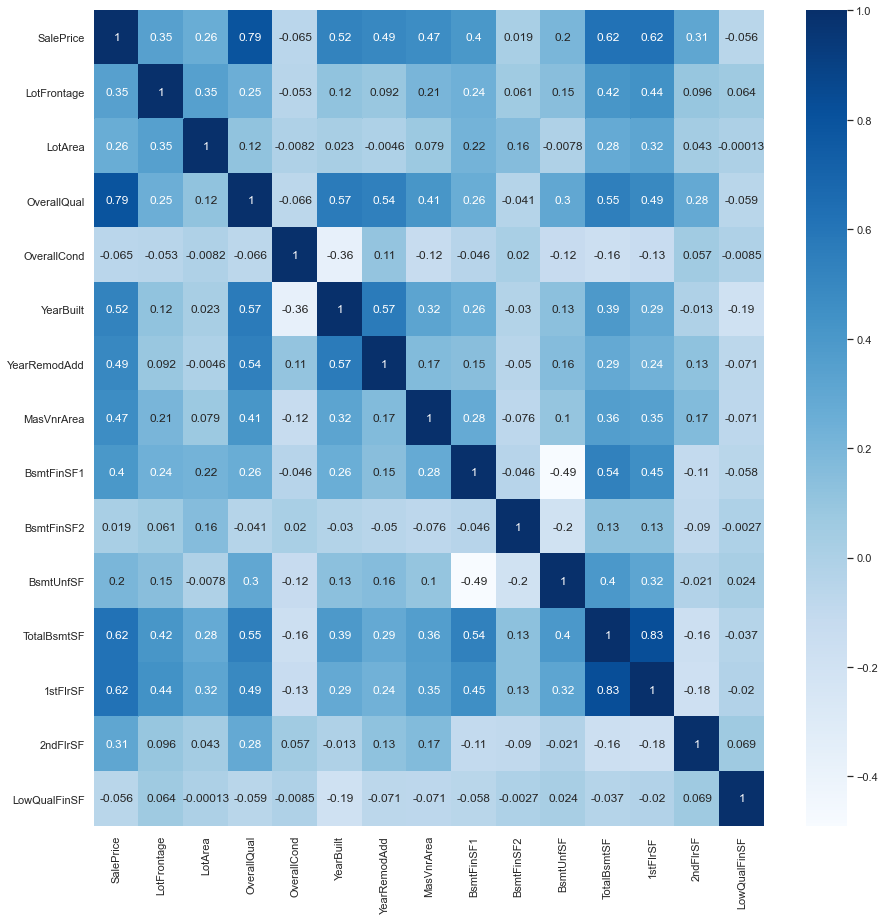

In [15]:
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Note: we got similar diagrams from `pandas_profiler`. 

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

## Feature selection intro (5 min)

- What is feature selection?
- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 
- Very related to looking at feature importances.

In [ ]:
df_train.columns

Which of these features are useful?

Why we might want to ask this? Why not just use all of them, even the fairly unimportant ones?

- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Computation: Models fit/predict faster with fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?
  - Think about the random noise column in hw5.
  - What does it do to training error?
  - What does it do to validation error?

How to do feature selection? The main approaches I will recommend in this course:

1. Domain knowledge
2. Importance-based feature elimination

Removed from the course: lasso

## Feature selection: importance-based feature elimination (15 min)

- We already had a whole lecture on feature importances.
- Let's use these importances to eliminate unimportant features (i.e., those with low importance).
- Basic idea: throw away the least important feature.

#### Recursive feature elimination 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!


In scikit-learn, we'll do this using `RFE`:

In [16]:
from sklearn.feature_selection import RFE

Let's look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

- **Note**: `RFE` not currently set up to work well with `Pipeline` or `TransformedTargetRegressor` !!
- See https://github.com/scikit-learn/scikit-learn/issues/15154, https://github.com/scikit-learn/scikit-learn/issues/9606, https://github.com/scikit-learn/scikit-learn/issues/15312

In [17]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [18]:
len(X_train_enc.columns)

292

In [19]:
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Exterior1st_Wd Sdng,Exterior1st_WdShing,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.28498,0.064219,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.28498,0.297501,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.28498,0.023451,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.28498,-1.038776,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.28498,-0.286837,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
lr = Ridge(alpha=100)

In [21]:
cross_validate_std(lr, X_train_enc, y_train_log, return_train_score=True, cv=10)

fit_time           0.010989
score_time         0.005164
test_score         0.856698
train_score        0.898979
std_test_score     0.096162
std_train_score    0.005990
dtype: float64

In [22]:
lr.fit(X_train_enc, y_train_log);

In [38]:
lr.score(X_train_enc, y_train_log)

0.8981098599473102

In [23]:
lr.score(X_test_enc, y_test_log)

0.9051318521975947

In [24]:
X_test_enc.shape

(365, 292)

In [40]:
coef_df = pd.DataFrame(data=np.abs(lr.coef_), index=X_train_enc.columns, columns=["Coefficients"]).sort_values(by="Coefficients", ascending=False)
coef_df

,Coefficients
OverallQual,0.079477
GarageCars,0.044766
GrLivArea,0.043596
OverallCond,0.040942
BsmtQual,0.035982
...,...
Exterior1st_CBlock,0.000075
Exterior2nd_CBlock,0.000075
SaleType_ConLI,0.000064
Exterior1st_Stone,0.000058


Select the top 30 features, one at a time, based on the absolute value of `model.coef_`:

In [35]:
rfe = RFE(lr, n_features_to_select=30)
rfe.fit(X_train_enc, y_train_log);

In [36]:
rfe.score(X_train_enc, y_train_log)

0.876925559161639

In [37]:
rfe.score(X_test_enc, y_test_log)

0.8823400488225399

In [39]:
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns

Index(['OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'ExterQual', 'BsmtQual', 'Foundation_PConc',
       'BsmtExposure_Gd', 'MSSubClass_30', 'MSSubClass_160',
       'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'GarageType_Attchd', 'BsmtFinType1_Unf', 'CentralAir_N', 'CentralAir_Y',
       'BldgType_1Fam', 'MSZoning_C (all)', 'MSZoning_RL', 'MSZoning_RM',
       'SaleCondition_Abnorml', 'Condition1_Norm'],
      dtype='object')

Contrast with the top 30 by the ORIGINAL importances (absolute value coefficients):

In [42]:
coef_df.iloc[:30].index

Index(['OverallQual', 'GarageCars', 'GrLivArea', 'OverallCond', 'BsmtQual',
       'Neighborhood_Crawfor', 'Condition1_Norm', 'MSZoning_C (all)',
       '1stFlrSF', 'Neighborhood_NridgHt', 'MSZoning_RL', 'TotRmsAbvGrd',
       'Fireplaces', '2ndFlrSF', 'BldgType_1Fam', 'YearBuilt', 'MSSubClass_20',
       'Neighborhood_Somerst', 'Foundation_PConc', 'FullBath',
       'Neighborhood_Edwards', 'MSSubClass_30', 'BsmtFullBath',
       'BsmtFinType1_GLQ', 'MSSubClass_160', 'Exterior1st_BrkFace',
       'CentralAir_Y', 'CentralAir_N', 'SaleCondition_Abnorml',
       'BsmtFinType1_Unf'],
      dtype='object')

In [44]:
set(selected_columns.values) - set(coef_df.iloc[:30].index.values)

{'BsmtExposure_Gd',
 'ExterQual',
 'GarageType_Attchd',
 'MSZoning_RM',
 'TotalBsmtSF'}

In [45]:
rfe.ranking_ # may be different than the ranked feature importances!

array([129,  44,   1,   1,   1,  46, 193, 120, 104, 121,   1,   1,   1,
       195,   1,   1, 138,  19,  20,   1,   1,  91,   1,  58,  25, 250,
       161, 102,  26,  59, 205,  69,   1, 151,   1, 143,  11,   4,  53,
        23,  39,  96,  68, 119,   1, 111, 256, 196, 181,  55, 148, 134,
       157, 204, 171, 172,  93, 170, 162, 201, 126, 133, 144, 208, 251,
        70, 145, 159, 160, 261, 241,  12, 210,  33,  38, 247,   1, 232,
        36,   7,   1, 207, 248,  54, 178,  40, 253, 142, 214,  92, 123,
         1,  89, 209,  29, 168,  60,  15, 149, 112, 175,  74, 113,  75,
       114, 263,  27, 180, 203,   5,  48, 231, 192, 221, 236, 176, 259,
       110, 234, 100, 130, 244, 122, 229,  52, 154, 198,  85,  98, 217,
        95,  64,  66,  81,   1,   3,  45,  22,  21,  79, 197, 165,  86,
        35,   1,  34, 255,  77,  94,   1,  14, 135, 109, 163, 139,   1,
       153, 179, 141,  90, 202, 125,  73, 199, 140, 156, 106, 164,  50,
       185,  61, 230, 200, 184, 103, 228, 186, 222, 215, 218, 24

We can do this same thing with a random forest. `RFE` will automatically use the random forests's `feature_importances_` instead of linear regression's `coef_`.

In [46]:
rf = RandomForestRegressor(random_state=123, max_depth=5, n_estimators=10)
rf.fit(X_train_enc, y_train_log);
rf.score(X_train_enc, y_train_log)

0.8891910313672117

In [47]:
rf.score(X_test_enc, y_test_log)

0.819405420056765

In [48]:
rfe = RFE(rf, n_features_to_select=100)
rfe.fit(X_train_enc, y_train_log);

In [49]:
rfe.score(X_train_enc, y_train_log)

0.8900923726684768

In [50]:
rfe.score(X_test_enc, y_test_log)

0.8204816375480437

# TODO

plot train and test error (or really train and valid error) vs. number of feature selected

- In this case the model was overfitting and feature selection helped a tiny bit.
- But we may have achieved the same by tuning hyperparameters.

What about categorical features?

In [55]:
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns.values

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'YrSold', 'ExterQual', 'ExterCond', 'BsmtQual',
       'HeatingQC', 'KitchenQual', 'PoolQC', 'RoofStyle_Hip',
       'Fence_GdWo', 'BsmtExposure_No', 'MSSubClass_20', 'MSSubClass_30',
       'MSSubClass_60', 'MoSold_10', 'MoSold_12', 'LandSlope_Gtl',
       'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn',
       'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace',
       'Neighborhood_Crawfor', 'Neighborhood_Gilbert',
       'GarageType_Detchd', 'Alley_?', 'Alley_Grvl', 'Alley_Pave',
       'MasVnrType_?', 'MasVnrType_BrkCmn'

In [56]:
removed_columns = [col for col in X_train_enc.columns if col not in selected_columns]
removed_columns;

- Does it make sense that we removed `BldgType_Duplex` but kept `BldgType_1Fam`?
  - This is a matter of opinion, I guess.
- There are more sophisticated ways of selecting categorical features.
- This seems to be unresolved in sklearn: https://github.com/scikit-learn/scikit-learn/issues/8480

#### How to choose the number of features to select?

- Suppose you don't know the number of relevant features in advance, 
- You can find them using cross validation with [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)
  - You would definitely not want to use training error! (Why?)

In [57]:
lr = Ridge(alpha=100)

rfe_cv = RFECV(lr)
rfe_cv.fit(X_train_enc, y_train_log)
print('Number of selected features: %d/%d' % (rfe_cv.n_features_, X_train_enc.shape[1]))
# print('Feature mask:', rfe_cv.support_)

Number of selected features: 60/292


- It stopped once it got to 60 features.
- Dropping down to 59 would lower the cross-validation score.
  - This is similar to using cross-validation to tune a hyperparameter.
  - Indeed, the number of selected features _is_ a hyperparameter.

Note: We are violating the Golden Rule a bit here, see above for sklearn issues.

#### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

#### (optional) Feature selection and OHE

- If you are using OHE with `drop='first'`, and then feature selection, the choice to drop the first is no longer arbitrary.
  - Say you have categories A,B,C,D
  - you drop='first'
  - so then you have B,C,D and 0,0,0 means A.
  - Then you feature select out D
  - Now you have B,C
  - but now 0,0 means A or D.
  - So now the feature removed by feature selection becomes mixed up with the "arbitrary" feature A.

## Break (5 min)

<br><br><br><br>

## Midterm review (30 min)

Practice question 1: Describe a scenario where you have an unbalanced training set and **would** want to set `class_weight='balanced'`, and a scenario where you have an unbalanced training set but **wouldn't** want to use it.

<br><br><br><br><br><br>

Answer (stealing from the chat): if your training data reflects deployment and you are not interested in 1 class over another( and care about accuracy) you wouldn’t want to use `class_weight=“balanced”`. 

Practice question 2: If we fit a logistic regression on a binary classification problem, how many coefficients will be learned? How can we interpret these coefficients?

<br><br><br><br><br><br>

One per transformed feature. The coefficients tell you how the probability score of the positive class would change when you increased that feature.

Practice question 3: We tend to split our data into three parts: train, (cross-)validation and test. Name an **advantage** ~~and a **disadvantage**~~ for taking this approach, as opposed to just using two splits (e.g. train and test).

<br><br><br><br><br><br>

Practice question 4: Suppose you train & tune a model and you get a final test score of 95%. Name three reasons why your deployment score might be lower.

<br><br><br><br><br><br>

## Q&A

Should we go through last year's midterm?